This notebook trains a model that is used to predict the value of a player

Step 1: Import Libraries

 Importing all necessary libraries for data handling, visualization, model training, and evaluation

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Step 2: Load Data

Loading the FIFA 21 dataset into a pandas DataFrame

In [25]:
fifa = pd.read_csv('players_21.csv')


Step 3: Preprocess

 Dropping unnecessary columns and cleaning the data

In [26]:
# Dropping unnecessary columns and cleaning the data
unwanted_cols = ['dob', 'sofifa_id', 'player_url', 'long_name', 'real_face',
                 'body_type', 'nation_position', 'nation_jersey_number', 'loaned_from']
fifa.drop(columns=unwanted_cols, inplace=True)

# Converting attribute columns to numeric format
numeric_cols = ['pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic']
for col in numeric_cols:
    fifa[col] = pd.to_numeric(fifa[col], errors='coerce')

# Keeping only relevant features and dropping rows with missing values
fifa = fifa[['value_eur', 'age', 'overall', 'potential'] + numeric_cols].dropna()

# Splitting the data into features (X) and target (y)
X = fifa.drop(columns='value_eur')
y = fifa['value_eur']

# Creating training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Step 4:  Exploratory Data Analysis (EDA)
 

Function to visualize the correlation matrix of all numeric features.

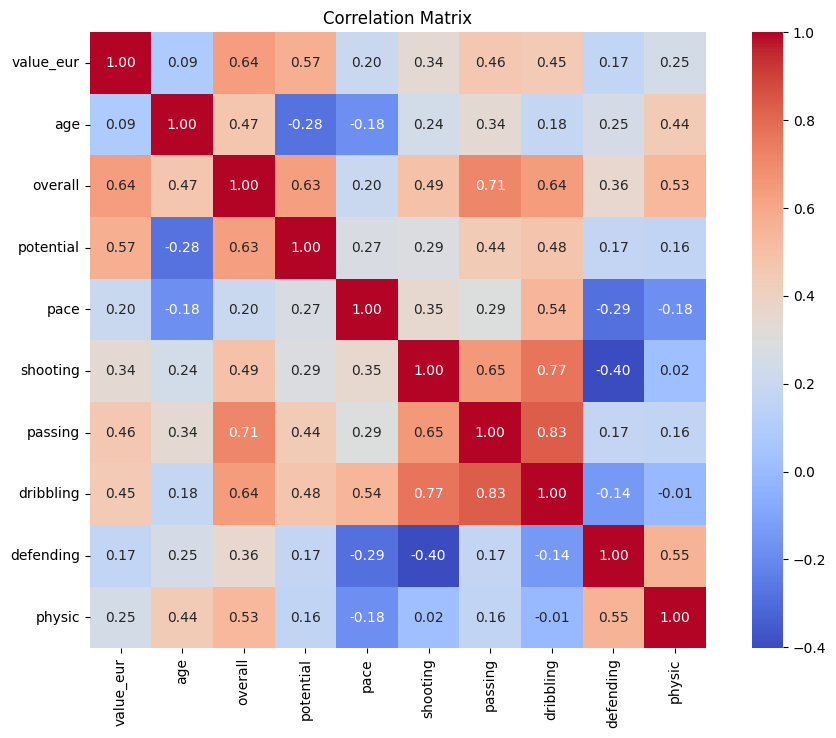

In [27]:
def plot_correlation_matrix(df):
    plt.figure(figsize=(12, 8))
    corr = df.corr()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
    plt.title('Correlation Matrix')
    plt.show()
    
# Plotting the correlation matrix
plot_correlation_matrix(fifa)




From the correlation matrix above we can see which attributes are most useful in determining a player's value.

Features that help prediction:
overall (0.64)

potential (0.57)

passing, dribbling, shooting (~0.45)

physic (0.25)

Less helpful:
defending (0.17)

pace (0.20)

age (0.09)


I had expected age to be a more important factor, as age increases value should decrease and it seems here there is no correlation. But this can be checked further with a feature importance.

Step 5: Train Model


Training a Random Forest Regressor to predict player market value.

In [28]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

Step 6: Evaluate Model

Function to evaluate model performance using MAE, MSE, and R² score.

In [29]:
y_pred = rf_model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

MAE: 136204.6694337385
MSE: 365814088109.24994
R² Score: 0.987109530950131


From the results above it can be seen that on average the predictions are off by roughly €136,204.67. This is a reasonable amount since the valuations are usually in the millions.

The MSE was very large since we are squaring errors and that doesn't help since there are likely to be outliers (more on that below). 

The R^2 score is high, too high. Given the nature of random forests, its likely that it just memorised the training data and was able to predict from there so I will test to see if it can generalise well.

In [30]:
# Compute 5-fold cross-validation R² scores
r2_scores = cross_val_score(rf_model, X, y, cv=5, scoring='r2')

# Print results
print("Cross-Validation R² scores:", r2_scores)
print("Average R²:", r2_scores.mean())
print("Min R²:", r2_scores.min())
print("Max R²:", r2_scores.max())

Cross-Validation R² scores: [-0.26527719  0.1482859   0.45179605  0.21081116 -3.43253183]
Average R²: -0.5773831827141076
Min R²: -3.4325318265900258
Max R²: 0.45179604859422395


From here the R^2 values show the model is poor and unreliable going even as low as -3.43. This means the model does over-fitting where it over applies the training data so in most cases it would be worse than predicting the mean. This may be because of the heavy skew of data where there are very large ranges of values. 

Step 7: Visualize Predictions


Function to create a scatter plot comparing predicted vs actual values

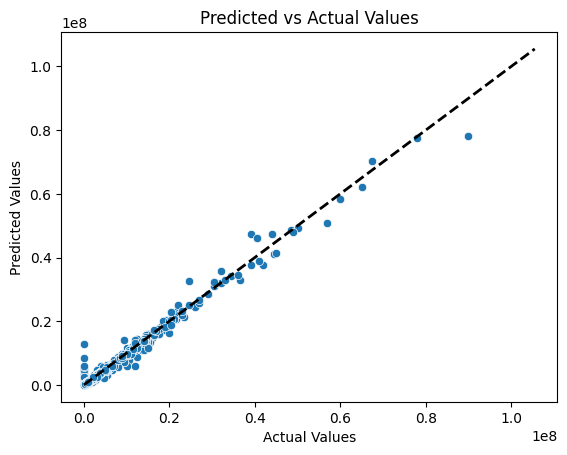

In [31]:
# plot predictions vs actual values
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.show()

Some players have an actual value of zero despite having a predicted value much higher, this would be because the model did not consider players that are free agents, I should have altered the data to remove players that had a transfer value of zero which would make the model more accurate since it only considers plays actively playing in a club.

Step 8: Feature Importance for Random Forest


Function to plot the importance of each feature in the trained model.

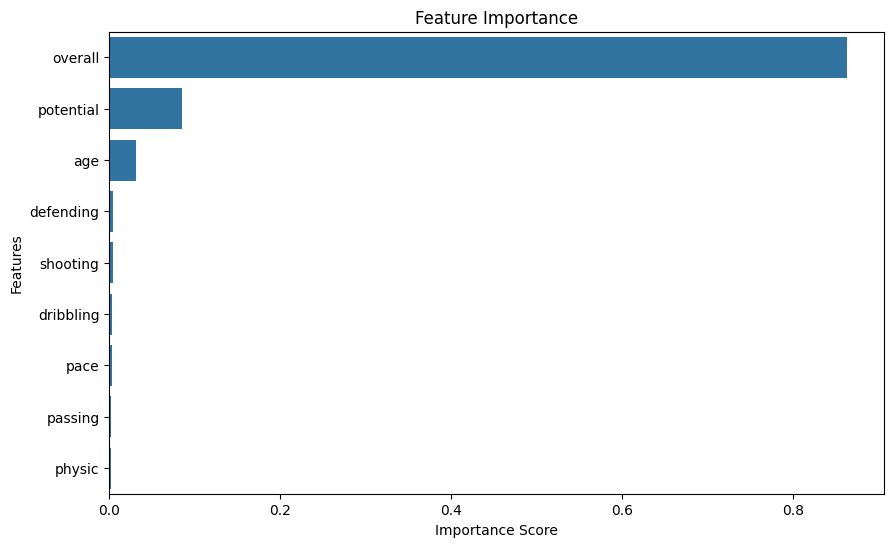

In [32]:
def plot_feature_importance(model, feature_names):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances[indices], y=np.array(feature_names)[indices])
    plt.title('Feature Importance')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.show()
    
# Plot feature importances for the trained Random Forest model.
plot_feature_importance(rf_model, X.columns)

So it can be seen that age is definitely of importance in determining the transfer value despite the actual data suggesting that it wasn't. 

I believe that the model may have noticed that the players with the most value were typically younger; the likes of Mbappe, Sancho and Haaland so it trained itself on that. However, in the actual data most young players have a low overall which is why age doesn't necessarily correlate to value, but the model here disagrees and that is the result of having extreme ends of transfer values. The players I mentioned have a much higher value than most players working in the models favour.